In [1]:
!pip install keras-tuner

In [2]:
import tensorflow as tf
import keras_tuner
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Input
from keras_tuner.tuners import RandomSearch, BayesianOptimization, Hyperband
from hyperopt import fmin, tpe, hp, anneal, Trials, space_eval

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


In [3]:
dataset = 'mnist'

if dataset == 'mnist':
    # Load the data
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
    img_rows, img_cols = 28, 28
    num_classes = 10
    channel = 1
elif dataset == 'cifar10':
    (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
    img_rows, img_cols = 32, 32
    num_classes = 10
    channel = 3

# Add the channel dimension to the images
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], channel, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], channel, img_rows, img_cols)
    input_shape = (channel, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channel)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channel)
    input_shape = (img_rows, img_cols, channel)

# Normalize the pixel values to the range of [0, 1]
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
    

In [4]:
# Our CNN model
def build_model(hp):
    model = Sequential()
    hp_layers = hp.Choice('layers', values=[1, 2])
    hp_dropout = hp.Float('dropout', 0, 0.5, step=0.1)
    hp_lr = hp.Float('learning_rate', 0.0001, 0.005, step=0.001)
    hp_filters1 = hp.Int('filters_input_layer', min_value=32, max_value=128, step=32)

    # Input layer
    model.add(Conv2D(filters=hp_filters1, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())

    for i in range(hp_layers):
        hp_filters2 = hp.Int(f'filters_conv_layer{i}', min_value=32, max_value=128, step=32)
        model.add(Conv2D(filters=hp_filters2, kernel_size=3, activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2,2)))
        model.add(Dropout(hp_dropout))

    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))

    # Compile model
    optimizer = keras.optimizers.Adam(learning_rate=hp_lr)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Random Search

In [5]:
RS_tuner = RandomSearch(build_model, max_trials=10, executions_per_trial=1, overwrite=True, objective="val_accuracy", directory="/tmp/tb", seed=1)
RS_tuner.search_space_summary()

Search space summary
Default search space size: 5
layers (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2], 'ordered': True}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.005, 'step': 0.001, 'sampling': None}
filters_input_layer (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': None}
filters_conv_layer0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': None}


In [6]:
RS_tuner.search(x_train, y_train, epochs=50, validation_split=0.2)

Trial 10 Complete [00h 05m 16s]
val_accuracy: 0.9938333630561829

Best val_accuracy So Far: 0.9946666955947876
Total elapsed time: 00h 53m 38s
INFO:tensorflow:Oracle triggered exit


In [7]:
RS_tuner.results_summary()

Results summary
Results in /tmp/tb\untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
layers: 2
dropout: 0.30000000000000004
learning_rate: 0.0011
filters_input_layer: 96
filters_conv_layer0: 128
filters_conv_layer1: 32
Score: 0.9946666955947876
Trial summary
Hyperparameters:
layers: 2
dropout: 0.30000000000000004
learning_rate: 0.0021
filters_input_layer: 96
filters_conv_layer0: 96
filters_conv_layer1: 64
Score: 0.9938333630561829
Trial summary
Hyperparameters:
layers: 2
dropout: 0.30000000000000004
learning_rate: 0.0041
filters_input_layer: 32
filters_conv_layer0: 128
filters_conv_layer1: 32
Score: 0.9938333630561829
Trial summary
Hyperparameters:
layers: 2
dropout: 0.2
learning_rate: 0.0031
filters_input_layer: 32
filters_conv_layer0: 64
filters_conv_layer1: 64
Score: 0.9931666851043701
Trial summary
Hyperparameters:
layers: 2
dropout: 0.2
learning_rate: 0.0011
filters_input_layer: 32
filters_conv_layer0: 128
filter

In [8]:
best_hp = RS_tuner.get_best_hyperparameters(1)[0]
print(best_hp.values)

{'layers': 2, 'dropout': 0.30000000000000004, 'learning_rate': 0.0011, 'filters_input_layer': 96, 'filters_conv_layer0': 128, 'filters_conv_layer1': 32}


In [48]:
# Build the model with the best hyperparameters
model_RS = RS_tuner.hypermodel.build(best_hp)
history = model_RS.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test), verbose=1)

Epoch 1/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1886 - accuracy: 0.9455 - val_loss: 0.0470 - val_accuracy: 0.9839
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0810 - accuracy: 0.9754 - val_loss: 0.0375 - val_accuracy: 0.9884
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0729 - accuracy: 0.9772 - val_loss: 0.0430 - val_accuracy: 0.9867
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0668 - accuracy: 0.9793 - val_loss: 0.0351 - val_accuracy: 0.9879
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0609 - accuracy: 0.9807 - val_loss: 0.0327 - val_accuracy: 0.9893
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0568 - accuracy: 0.9824 - val_loss: 0.0303 - val_accuracy: 0.9896
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0537 - accuracy: 0.9836 - val_loss: 0.0317 - val_accuracy:

In [49]:
# Results RS
RS_accuracy = history.history['val_accuracy']
RS_loss = history.history['val_loss']
RS_training_accuracy = history.history['accuracy']
RS_training_loss = history.history['loss']

# Hyperband

In [22]:
HB_tuner = Hyperband(build_model, max_epochs=25, factor=3, executions_per_trial=1, overwrite=True, objective="val_accuracy", directory="/tmp/tb", seed=1)
HB_tuner.search_space_summary()

Search space summary
Default search space size: 5
layers (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2], 'ordered': True}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.005, 'step': 0.001, 'sampling': None}
filters_input_layer (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': None}
filters_conv_layer0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': None}


In [23]:
HB_tuner.search(x_train, y_train, epochs=50, validation_split=0.2)

Trial 30 Complete [00h 02m 56s]
val_accuracy: 0.9925000071525574

Best val_accuracy So Far: 0.9928333163261414
Total elapsed time: 00h 31m 07s
INFO:tensorflow:Oracle triggered exit


In [24]:
HB_tuner.results_summary()

Results summary
Results in /tmp/tb\untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
layers: 2
dropout: 0.1
learning_rate: 0.0011
filters_input_layer: 64
filters_conv_layer0: 128
filters_conv_layer1: 96
tuner/epochs: 25
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.9928333163261414
Trial summary
Hyperparameters:
layers: 2
dropout: 0.2
learning_rate: 0.0031
filters_input_layer: 32
filters_conv_layer0: 64
filters_conv_layer1: 64
tuner/epochs: 25
tuner/initial_epoch: 9
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: ec758034f3bfd624809040e2818dabb1
Score: 0.9925833344459534
Trial summary
Hyperparameters:
layers: 2
dropout: 0.5
learning_rate: 0.0031
filters_input_layer: 32
filters_conv_layer0: 128
filters_conv_layer1: 96
tuner/epochs: 25
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.9925000071525574
Trial summary
Hyperparameters:
layers: 2
dropout: 0.30000000000000004
learning_rate: 0.0

In [25]:
best_hp = HB_tuner.get_best_hyperparameters(1)[0]
print(best_hp.values)

{'layers': 2, 'dropout': 0.1, 'learning_rate': 0.0011, 'filters_input_layer': 64, 'filters_conv_layer0': 128, 'filters_conv_layer1': 96, 'tuner/epochs': 25, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


In [50]:
# Build the model with the best hyperparameters
model_HB = HB_tuner.hypermodel.build(best_hp)
history = model_HB.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test), verbose=1)

Epoch 1/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1871 - accuracy: 0.9477 - val_loss: 0.0490 - val_accuracy: 0.9835
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0808 - accuracy: 0.9748 - val_loss: 0.0371 - val_accuracy: 0.9868
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0718 - accuracy: 0.9776 - val_loss: 0.0326 - val_accuracy: 0.9893
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0634 - accuracy: 0.9800 - val_loss: 0.0326 - val_accuracy: 0.9890
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0617 - accuracy: 0.9804 - val_loss: 0.0316 - val_accuracy: 0.9889
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0583 - accuracy: 0.9823 - val_loss: 0.0314 - val_accuracy: 0.9895
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0529 - accuracy: 0.9838 - val_loss: 0.0275 - val_accuracy

In [51]:
# Results Hyperband
HP_accuracy = history.history['val_accuracy']
HP_loss = history.history['val_loss']
HP_training_accuracy = history.history['accuracy']
HP_training_loss = history.history['loss']

# Gaussian Process

In [28]:
GP_tuner = BayesianOptimization(build_model, max_trials=10, executions_per_trial=1, overwrite=True, objective="val_accuracy", directory="/tmp/tb", seed=1)
GP_tuner.search_space_summary()

Search space summary
Default search space size: 5
layers (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2], 'ordered': True}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.005, 'step': 0.001, 'sampling': None}
filters_input_layer (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': None}
filters_conv_layer0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': None}


In [29]:
GP_tuner.search(x_train, y_train, epochs=50, validation_split=0.2)

Trial 10 Complete [00h 06m 01s]
val_accuracy: 0.9941666722297668

Best val_accuracy So Far: 0.9941666722297668
Total elapsed time: 00h 59m 09s
INFO:tensorflow:Oracle triggered exit


In [30]:
GP_tuner.results_summary()

Results summary
Results in /tmp/tb\untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
layers: 2
dropout: 0.5
learning_rate: 0.0041
filters_input_layer: 64
filters_conv_layer0: 128
filters_conv_layer1: 32
Score: 0.9941666722297668
Trial summary
Hyperparameters:
layers: 2
dropout: 0.5
learning_rate: 0.0041
filters_input_layer: 128
filters_conv_layer0: 128
filters_conv_layer1: 32
Score: 0.9940000176429749
Trial summary
Hyperparameters:
layers: 2
dropout: 0.5
learning_rate: 0.0041
filters_input_layer: 128
filters_conv_layer0: 96
filters_conv_layer1: 64
Score: 0.9933333396911621
Trial summary
Hyperparameters:
layers: 2
dropout: 0.5
learning_rate: 0.0041
filters_input_layer: 128
filters_conv_layer0: 32
filters_conv_layer1: 32
Score: 0.9930833578109741
Trial summary
Hyperparameters:
layers: 2
dropout: 0.5
learning_rate: 0.0041
filters_input_layer: 128
filters_conv_layer0: 128
filters_conv_layer1: 128
Score: 0.9930833578109741

In [31]:
best_hp = GP_tuner.get_best_hyperparameters(1)[0]
print(best_hp.values)

{'layers': 2, 'dropout': 0.5, 'learning_rate': 0.0041, 'filters_input_layer': 64, 'filters_conv_layer0': 128, 'filters_conv_layer1': 32}


In [52]:
# Build the model with the best hyperparameters
model_GP = GP_tuner.hypermodel.build(best_hp)
history = model_GP.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test), verbose=1)

Epoch 1/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1843 - accuracy: 0.9479 - val_loss: 0.0460 - val_accuracy: 0.9840
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0833 - accuracy: 0.9744 - val_loss: 0.0383 - val_accuracy: 0.9879
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0743 - accuracy: 0.9764 - val_loss: 0.0328 - val_accuracy: 0.9889
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0653 - accuracy: 0.9795 - val_loss: 0.0408 - val_accuracy: 0.9864
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0618 - accuracy: 0.9807 - val_loss: 0.0302 - val_accuracy: 0.9898
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0570 - accuracy: 0.9821 - val_loss: 0.0376 - val_accuracy: 0.9872
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0532 - accuracy: 0.9838 - val_loss: 0.0295 - val_accuracy

In [53]:
# Results Gaussian Process
GP_accuracy = history.history['val_accuracy']
GP_loss = history.history['val_loss']
GP_training_accuracy = history.history['accuracy']
GP_training_loss = history.history['loss']

# Results

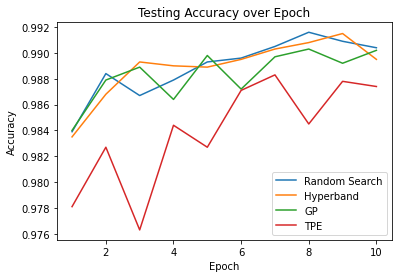

In [57]:
TPE_MNIST = np.load('TPE_MNIST.npy') # load
# plot
plt.plot(range(1,11), RS_accuracy)
plt.plot(range(1,11), HP_accuracy)
plt.plot(range(1,11), GP_accuracy)
plt.plot(range(1,11), TPE_MNIST)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Testing Accuracy over Epoch")
plt.legend(['Random Search', 'Hyperband', 'GP', 'TPE'], loc='lower right')
plt.show()

In [47]:
np.save('RS_data_mnist.npy', RS_accuracy)
np.save('HP_data_mnist.npy', HP_accuracy)
np.save('GP_data_mnist.npy', GP_accuracy)